Reading the "Reducing the Dimensionality of data with neural networks" paper by G. E. Hinton* and R. R. Salakhutdinov - https://www.cs.toronto.edu/~hinton/absps/science.pdf

Dimensionality reduction is the process of transforming data from a high dimensional space to a lower dimensional space (3D to 2D) while preserving as much information as possible during the reduction. It is useful because working with high dimensional data has some disadvantages (https://en.wikipedia.org/wiki/Curse_of_dimensionality) - more data is needed and organizing it is generally harder.

# Loading MNIST

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                               shuffle=True, num_workers=2)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                              shuffle=True, num_workers=2)

7.9%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




55.6%

100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Visualizing an image from MNIST

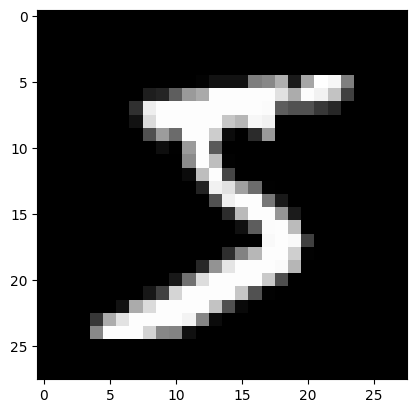

In [9]:
def show_image(image):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()
    
x = train_dataloader.dataset[0][0]

show_image(x)

There are a few methods for reducing the dimensionality - heatmaps, t-SNE, Multi-Dimensional Scaling, etc. A pretty simple and standard way of reducing the dimensionality is a method called Principal Component Analysis (PCA):

# Applying Principal Component Analysis (PCA):

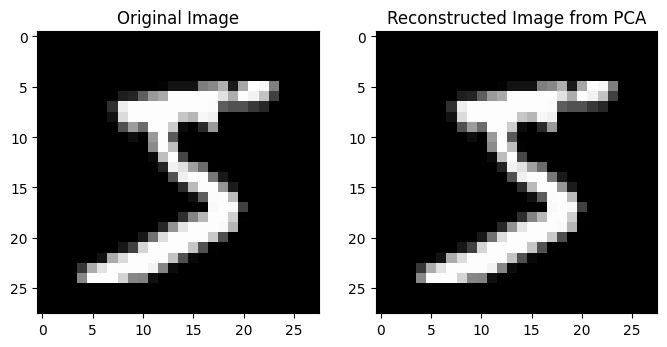

In [10]:
x_flattened = x.view(-1)

mean_x = torch.mean(x_flattened)

# Compute the covariance matrix
centered_image = x_flattened - mean_x
covariance_matrix = torch.mm(centered_image.unsqueeze(1), centered_image.unsqueeze(0)) / (x_flattened.numel() - 1)

# Compute the eigenvectors using SVD
_, s, v = torch.svd(covariance_matrix)

# Project the data onto the principal components
num_components = 10  # You can choose any desired number of principal components
principal_components = v[:, :num_components].t()  # Transpose for proper matrix multiplication
projected_data = torch.mm(centered_image.unsqueeze(0), principal_components.t())

# Reconstruct the data from the principal components
reconstructed_data = torch.mm(projected_data, principal_components) + mean_x.view(1, -1)

# Reshape the reconstructed data back to the original image size
reconstructed_image = reconstructed_data.view(x.size())

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.squeeze().detach(), cmap='gray')
plt.title('Reconstructed Image from PCA')
plt.show()

# Using Autoencoder for dimensionality reduction

### Naive Deep Autoencoder

In [11]:
from torchvision.utils import make_grid

def display_output(v0, vk, dim1=28, dim2=28, v0_fname=None, vk_fname=None):
    print("Original (top) and Reconstructed (bottom)")
    img = make_grid(v0.view(v0.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if v0_fname is not None:
        plt.savefig(v0_fname)
    plt.show()
    img = make_grid(vk.view(vk.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if vk_fname is not None:
        plt.savefig(vk_fname)    
    plt.show()

Epoch 0: 0.06715990233221161
Epoch 1: 0.05106486672801631
Epoch 2: 0.04247576895076583
Epoch 3: 0.039892603601537534
Epoch 4: 0.03830711522113794
Epoch 5: 0.03730700419012354
Epoch 6: 0.03655583972433038
Epoch 7: 0.0360011514018117
Epoch 8: 0.03567658466245256
Epoch 9: 0.035359198495602685
Original (top) and Reconstructed (bottom)


FileNotFoundError: [Errno 2] No such file or directory: 'images/original_digits.png'

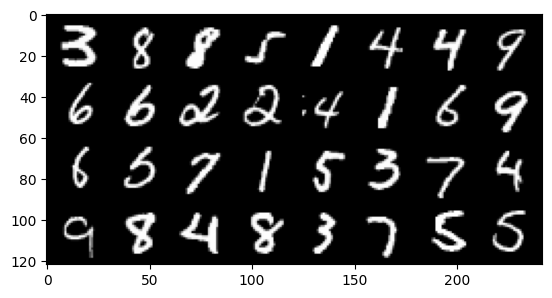

In [15]:
from restricted_boltzmann_machine import RestrictedBoltzmannMachine
from deep_autoencoder import DeepAutoencoder, NaiveDeepAutoencoder
import os
import sys
from torch import nn
from torch import optim

module_path = os.path.abspath('.')
if module_path not in sys.path:
    sys.path.append(module_path)


def flatten_input(dataloader):
    pixels = 784
    flat_input = []
    labels = []
    for features, targets in dataloader:
        flat_input.append(features.view(-1, pixels).detach().numpy())
        labels.append(targets.detach().numpy())
    return np.concatenate(flat_input), np.concatenate(labels)


flat_train_input, train_labels = flatten_input(train_dataloader)
flat_test_input, test_labels = flatten_input(test_dataloader)
train_dataloader_flat = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    torch.Tensor(flat_train_input)), batch_size=64, shuffle=False)

learning_rate = 1e-3
naive_deep_autoencoder = NaiveDeepAutoencoder([784, 1000, 500, 250, 2])
loss = nn.MSELoss()
optimizer = optim.Adam(naive_deep_autoencoder.parameters(), learning_rate)
epochs = 10

running_loss = float("inf")
for epoch in range(epochs):
    losses = []
    for i, data_list in enumerate(train_dataloader_flat):
      data = data_list[0]
      v_pred = naive_deep_autoencoder(data)
      batch_loss = loss(data, v_pred)
      losses.append(batch_loss.item())
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
    running_loss = np.mean(losses)
    print(f"Epoch {epoch}: {running_loss}")
    if epoch % 10 == 9:
      display_output(data, v_pred, v0_fname="./images/original_digits.png", vk_fname="./images/reconstructed_digits_naive_dae.png")
